# Request Serving Architecture Overhead

In [1]:
import os
import json
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import re

In [2]:
print("="*80)
print("Request Serving Architecture Overhead")
print("-"*80)

Request Serving Architecture Overhead
--------------------------------------------------------------------------------


In [3]:
# ensure figures dir exists
os.makedirs('figures', exist_ok=True)

## Read Data

In [4]:
REQUEST_LOG_DIR = '../dataset/serving_architecture'

In [5]:
# read aws data
with open(os.path.join(REQUEST_LOG_DIR, "aws128/cloudwatch.json")) as f:
    aws_128mb = json.load(f)

with open(os.path.join(REQUEST_LOG_DIR, "aws1769/cloudwatch.json")) as f:
    aws_1769mb = json.load(f)

In [6]:
# read gcp data
with open(os.path.join(REQUEST_LOG_DIR, "gcp80mc/cloud-log.json")) as f:
    gcp_80mc = json.load(f)

with open(os.path.join(REQUEST_LOG_DIR, "gcp1000mc/cloud-log.json")) as f:
    gcp_1000mc = json.load(f)

In [7]:
# read azure data
azure_consumption = pd.read_csv(os.path.join(REQUEST_LOG_DIR, "azure-consumption/query_data.csv"))

In [8]:
azure_customDimensions = azure_consumption['customDimensions'].to_list()
azure_customDimensions = [json.loads(x) for x in azure_customDimensions]

## Process Data

In [9]:
aws_128mb = [x for x in aws_128mb if "Duration:" in x["message"]]
aws_1769mb = [x for x in aws_1769mb if "Duration:" in x["message"]]
aws_128mb = [float(re.search(r"Duration: ([0-9.]+)", x["message"]).group(1)) for x in aws_128mb]
aws_1769mb = [float(re.search(r"Duration: ([0-9.]+)", x["message"]).group(1)) for x in aws_1769mb]

In [10]:
gcp_80mc = [x for x in gcp_80mc if "latency" in x['httpRequest'].keys()]
gcp_1000mc = [x for x in gcp_1000mc if "latency" in x['httpRequest'].keys()]
gcp_80mc = [float(x['httpRequest']['latency'].split("s")[0]) * 1000 for x in gcp_80mc]
gcp_1000mc = [float(x['httpRequest']['latency'].split("s")[0]) * 1000 for x in gcp_1000mc]

In [11]:
azure_consumption = azure_consumption['duration'].to_list()

In [12]:
# keep the 4000 data points in the middle
aws_128mb = aws_128mb[500:4500]
aws_1769mb = aws_1769mb[500:4500]
gcp_80mc = gcp_80mc[500:4500]
gcp_1000mc = gcp_1000mc[500:4500]
azure_consumption = azure_consumption[500:4500]

In [13]:
np.mean(gcp_1000mc)

np.float64(2.36920772125)

In [14]:
np.mean(azure_consumption)

np.float64(5.927323599999999)

In [15]:
np.mean(aws_128mb), np.mean(aws_1769mb), np.mean(gcp_80mc), np.mean(gcp_1000mc), np.mean(azure_consumption)

(np.float64(1.1726050000000001),
 np.float64(1.130515),
 np.float64(5.23529820125),
 np.float64(2.36920772125),
 np.float64(5.927323599999999))

## Plotting

Figure saved to figures/empty_function_latency.pdf


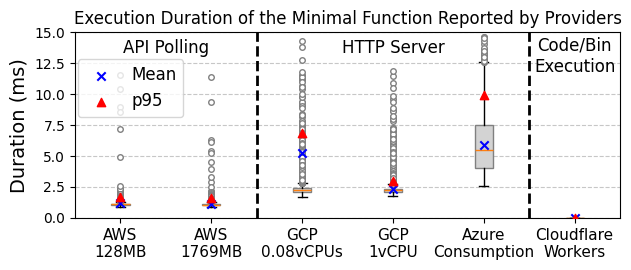

In [16]:
data = [
    aws_128mb,
    aws_1769mb,
    gcp_80mc,
    gcp_1000mc,
    azure_consumption,
    np.zeros_like(aws_128mb),
]
positions = [1, 2, 3, 4, 5, 6]
labels = ['AWS\n128MB', 'AWS\n1769MB', 'GCP\n0.08vCPUs', 'GCP\n1vCPU', 'Azure\nConsumption', 'Cloudflare\nWorkers']

fig, ax = plt.subplots(figsize=(6.4, 2.8))

flierprops = {
    'marker':        'o',
    'markerfacecolor':'white',
    'markeredgecolor':'gray',
    'markersize':    4,
    'linestyle':     'none'
}
bp = ax.boxplot(
    data,
    positions=positions,
    widths=0.2,
    patch_artist=True,
    flierprops=flierprops,
    boxprops=dict(facecolor='lightgray', color='gray'),
)

for flier in bp['fliers']:
    flier.set_rasterized(True)

means = [np.mean(d) for d in data]
p95s  = [np.percentile(d, 95) for d in data]

ax.scatter(positions, means, marker='x', label='Mean', zorder=100, color='blue')
ax.scatter(positions, p95s, marker='^', label='p95', zorder=100, color='red')

ax.axvline(x=2.5, color='black', linestyle='--', linewidth=2)
ax.axvline(x=5.5, color='black', linestyle='--', linewidth=2)

y_max = ax.get_ylim()[1]
y_text = 13
ax.text((1+2)/2, y_text, 'API Polling', ha='center', va='bottom', fontsize=12)
ax.text((3+5)/2, y_text, 'HTTP Server', ha='center', va='bottom', fontsize=12)
ax.text(6, 11.5, 'Code/Bin\nExecution', ha='center', va='bottom', fontsize=12)

ax.set_xticks(positions)
ax.set_xticklabels(labels, rotation=0, ha='center', fontsize=11)
ax.set_ylabel('Duration (ms)', fontsize=14)
ax.set_title('Execution Duration of the Minimal Function Reported by Providers')
ax.set_ylim(0, 15)
ax.grid(axis='y', linestyle='--', alpha=0.7)
ax.legend(loc='upper left', fontsize=12, bbox_to_anchor=(-0.01, 0.9))

plt.tight_layout()
plt.savefig("figures/empty_function_latency.pdf", format='pdf', dpi=300, bbox_inches='tight')
print("Figure saved to figures/empty_function_latency.pdf")
plt.show()

In [17]:
print('-'*80)
print("Average Latency:")
for x, y in zip(labels, means):
    print(f"{x.replace('\n', ' ')}: {y:.2f} ms")

--------------------------------------------------------------------------------
Average Latency:
AWS 128MB: 1.17 ms
AWS 1769MB: 1.13 ms
GCP 0.08vCPUs: 5.24 ms
GCP 1vCPU: 2.37 ms
Azure Consumption: 5.93 ms
Cloudflare Workers: 0.00 ms


In [18]:
print('-'*80)
print("p95 Latency:")
for x, y in zip(labels, p95s):
    print(f"{x.replace('\n', ' ')}: {y:.2f} ms")

--------------------------------------------------------------------------------
p95 Latency:
AWS 128MB: 1.67 ms
AWS 1769MB: 1.63 ms
GCP 0.08vCPUs: 6.88 ms
GCP 1vCPU: 2.98 ms
Azure Consumption: 9.93 ms
Cloudflare Workers: 0.00 ms
